# Rakuten USA - Data Engineering Test

### Goal
The goal of this test is not meant to be exhaustive, but we do want to test your skills in analytical thinking, SQL, data wrangling, data analysis, and data visualization.

### Expectations
You can expect this test to use the following technologies:
- Python3
- Jupyter Notebook
- PySpark
- PySpark SQL

This test will cover the following areas: 
- Data cleaning/wrangling
- Exploratory Data Analysis (EDA)
- Data Visualization 

This test should take you no more than 2-4 hours.

### What to turn in, and where to send your test
Please email stirling.waite@rakuten with your finished notebook
- rakuten_engineering_test.ipynb
 
### Questions?
Feel free to email me or call me with any questions about this test
- stirling.waite@rakuten.com
- 801-856-1426

### --------------------------------------------------------------------------------------------------------------------------------

# About The Dataset

Below you will find a modified free Kaggle competition dataset from https://www.kaggle.com/mayank811/employee-reviews/data using scraped data from Glassdoor.com.

## Context
- Over 67k employee reviews for Google, Amazon, Facebook, Apple, Microsoft, and Netflix.
- Web scraped from Glassdoor

## Content
This dataset contains employee reviews separated into the following categories:

- **Index:** index
- **Company:** Company name
- **Location:** This dataset is global, as such it may include the country's name in parenthesis [i.e "Toronto, ON(Canada)"]. However, if the location is in the USA then it will only include the city and state[i.e "Los Angeles, CA" ]
- **Date Posted:** in the following format MM DD, YYYY
- **Job-Title:** This string will also include whether the reviewer is a 'Current' or 'Former' Employee at the time of the review
- **Summary:** Short summary of employee review
- **Pros:** Pros
- **Cons:** Cons
- **Overall Rating:** 1-5
- **Work/Life Balance Rating:** 1-5
- **Culture and Values Rating:** 1-5
- **Career Opportunities Rating:** 1-5
- **Comp & Benefits Rating:** 1-5
- **Senior Management Rating:** 1-5
- **Helpful Review Count:** 1-5

**Link to Review:** This will provide you with a direct link to the page that contains the review. However it is likely that this link will be outdated

**NOTE:** 'none' is placed in all cells where no data value was found.



### --------------------------------------------------------------------------------------------------------------------------------

## PySpark Initialization

In [52]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import re
import pyspark
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
from pyspark.sql import functions as fn
from pyspark.sql import types as t
from pyspark.sql.types import *
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


In [2]:
conf = SparkConf()\
                .setMaster("local[*]")\
                .setAppName("rakutenHomework")
        
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName("spark play").getOrCreate()

## Read Dataset into Spark

In [3]:
reviews_df = spark.read.csv("employee_reviews_usa.csv", header=True, mode="DROPMALFORMED", inferSchema='true',\
                            encoding="utf-8")
print(reviews_df.count())
reviews_df.show(5)

27779
+---+-------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+
|_c0|company|         location|        dates|           job_title|             summary|                pros|                cons|      advice_to_mgmt|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|                link|
+---+-------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+
|  0| google|Mountain View, CA|  Feb 8, 2015|Current Employee

## Check the Schema 

In [4]:
reviews_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- company: string (nullable = true)
 |-- location: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- pros: string (nullable = true)
 |-- cons: string (nullable = true)
 |-- advice_to_mgmt: string (nullable = true)
 |-- overall_ratings: string (nullable = true)
 |-- work_balance_stars: string (nullable = true)
 |-- culture_values_stars: string (nullable = true)
 |-- carrer_opportunities_stars: string (nullable = true)
 |-- comp_benefit_stars: string (nullable = true)
 |-- senior_mangemnet_stars: string (nullable = true)
 |-- helpful_count: string (nullable = true)
 |-- link: string (nullable = true)



## Exploratory Analysis of the data:

1. _c0 needs to be removed as it is an index column
2. company : No changes required (Categorical Column)
3. Location: Split it into 3 columns : City, State, Country
4. Date column needs some formatting
5. job_title : Modify it into Current Employee column with Boolean values. Also remove the "Former/Current employee" tag from the job_title column.
6. Summary: Check this more (drop this) 
7. pros: drop this
8. cons : drop this
9. advice_to_mgmt : drop this (none values present)
10. overall_ratings: string 
11. work_balance_stars : string (none values present)
12. culture_values_stars : string : lot of none values
13. carrer_opportunities_stars: string : none values present
14. comp_benefit_stars: string : none values present
15. senior_mangemnet_stars: string
16. helpful_count: what is this column for? It has values greater than 5. Will drop this. 
17. Link: not useful

## Drop the columns which are not needed

In [5]:
df = reviews_df.drop("_c0", "summary", "pros", "cons", "advice_to_mgmt", "helpful_count", "link")
#df.columns
#df.describe().show()
#reviews_df.describe().show()

## Create the formatted date column 

In [6]:
review_date_udf = fn.udf(
    lambda x: datetime.strptime(x, ' %b %d, %Y'), DateType()
)

df = df.withColumn('review_date', review_date_udf(col('dates')))



## Drop the older date column

In [7]:
df = df.drop("dates")


## Split the location column

In [8]:
split_col = fn.split(df['location'], ',')
df = df.withColumn('city', split_col.getItem(0))
df = df.withColumn('state', split_col.getItem(1))


## Create the Country column

In [9]:
df = df.withColumn("country", lit("US"))

## Drop the location column

In [10]:
df = df.drop("location")


## Split the job_title column into current_employee and job_title columns

In [11]:
df = df.withColumn('current_employee', split(df['job_title'], '-')[0])
df = df.withColumn('job_title', split(df['job_title'], '-')[1])


## Create a boolean value column for current_employee column

In [12]:
df = df.withColumn("current_employee", fn.when(fn.col("current_employee").like("%Current Employee%"), 1).otherwise(0))

In [13]:
#df.show()

## Rearrange the order of the columns


In [14]:
# management, carrer spelling mistake
df=df.select("company","city","state","country","review_date","job_title",\
             "current_employee","overall_ratings","work_balance_stars",\
             "culture_values_stars","carrer_opportunities_stars","comp_benefit_stars","senior_mangemnet_stars")
df.show(5)

+-------+-------------+-----+-------+-----------+-------------------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+
|company|         city|state|country|review_date|          job_title|current_employee|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|
+-------+-------------+-----+-------+-----------+-------------------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+
| google|Mountain View|   CA|     US| 2015-02-08| Anonymous Employee|               1|            5.0|               2.0|                 5.0|                       5.0|               4.0|                   5.0|
| google|Mountain View|   CA|     US| 2018-12-09|               SDE2|               0|            5.0|               4.0|                 4.0|          

## Check for the Null/None values

In [15]:
df.filter(df.work_balance_stars.isNull()).count()

# approx 5000 rows with None values

0

## Removing the None values. Why/Why not?
1. If none values are removed approx 5000 rows are removed from the dataset. 5000/27000 i.e. loss of 18% of data. 
2. If imputation is done on the none values it will bring 18% noise in the data
3. I feel imputation needs to be done with more relevant data and not just random values

## Replace "None" with Null

In [16]:
df.describe().show()

+-------+-------+--------+-----+-------+---------+-------------------+------------------+------------------+--------------------+--------------------------+------------------+----------------------+
|summary|company|    city|state|country|job_title|   current_employee|   overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|
+-------+-------+--------+-----+-------+---------+-------------------+------------------+------------------+--------------------+--------------------------+------------------+----------------------+
|  count|  27779|   27779|27779|  27779|    27779|              27779|             27779|             27779|               27779|                     27779|             27779|                 27779|
|   mean|   null|    null| null|   null|     null| 0.6448396270564095|3.7785737427553188|3.3734953271028036|  3.7328037709497206|         3.617313734290844|3.9743589743589745|     3.300279013649046|
| std

In [17]:
# Function to replace None values
def replaceNone(x):
    return when(col(x) == ("none" or "None" or "NONE") , None).otherwise(col(x))

In [18]:
df = df.withColumn("senior_mangemnet_stars", replaceNone("senior_mangemnet_stars")).\
withColumn("comp_benefit_stars", replaceNone("comp_benefit_stars")).\
withColumn("carrer_opportunities_stars", replaceNone("carrer_opportunities_stars")).\
withColumn("culture_values_stars", replaceNone("culture_values_stars")).\
withColumn("work_balance_stars", replaceNone("work_balance_stars")).\
withColumn("overall_ratings", replaceNone("overall_ratings"))


## Check for Null values present in each column

In [19]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+----+-----+-------+-----------+---------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+
|company|city|state|country|review_date|job_title|current_employee|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|
+-------+----+-----+-------+-----------+---------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+
|      0|   0|    0|      0|          0|        0|               0|              0|              1029|                4867|                      1043|              1025|                  1257|
+-------+----+-----+-------+-----------+---------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+



## Change the required columns to integer type

In [20]:
df.printSchema()

root
 |-- company: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = false)
 |-- review_date: date (nullable = true)
 |-- job_title: string (nullable = true)
 |-- current_employee: integer (nullable = false)
 |-- overall_ratings: string (nullable = true)
 |-- work_balance_stars: string (nullable = true)
 |-- culture_values_stars: string (nullable = true)
 |-- carrer_opportunities_stars: string (nullable = true)
 |-- comp_benefit_stars: string (nullable = true)
 |-- senior_mangemnet_stars: string (nullable = true)



## Convert to apt Type

In [21]:
df = df.withColumn("overall_ratings", df.overall_ratings.cast(IntegerType()))
df = df.withColumn("work_balance_stars", df.work_balance_stars.cast(FloatType()))
df = df.withColumn("culture_values_stars", df.culture_values_stars.cast(IntegerType()))
df = df.withColumn("carrer_opportunities_stars", df.carrer_opportunities_stars.cast(FloatType()))
df = df.withColumn("comp_benefit_stars", df.comp_benefit_stars.cast(FloatType()))
df = df.withColumn("senior_mangemnet_stars", df.senior_mangemnet_stars.cast(FloatType()))

In [22]:
df.printSchema()

root
 |-- company: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = false)
 |-- review_date: date (nullable = true)
 |-- job_title: string (nullable = true)
 |-- current_employee: integer (nullable = false)
 |-- overall_ratings: integer (nullable = true)
 |-- work_balance_stars: float (nullable = true)
 |-- culture_values_stars: integer (nullable = true)
 |-- carrer_opportunities_stars: float (nullable = true)
 |-- comp_benefit_stars: float (nullable = true)
 |-- senior_mangemnet_stars: float (nullable = true)



In [23]:
df.describe().show()

+-------+-------+--------+-----+-------+---------+-------------------+------------------+------------------+--------------------+--------------------------+------------------+----------------------+
|summary|company|    city|state|country|job_title|   current_employee|   overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|
+-------+-------+--------+-----+-------+---------+-------------------+------------------+------------------+--------------------+--------------------------+------------------+----------------------+
|  count|  27779|   27779|27779|  27779|    27779|              27779|             27779|             26750|               22912|                     26736|             26754|                 26522|
|   mean|   null|    null| null|   null|     null| 0.6448396270564095|3.7785737427553188|3.3734953271028036|  3.7328037709497206|         3.617313734290844|3.9743589743589745|     3.300279013649046|
| std

## No Outliers found


In [24]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+----+-----+-------+-----------+---------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+
|company|city|state|country|review_date|job_title|current_employee|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|
+-------+----+-----+-------+-----------+---------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+
|      0|   0|    0|      0|          0|        0|               0|              0|              1029|                4867|                      1043|              1025|                  1257|
+-------+----+-----+-------+-----------+---------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+



## Imputation

- There are approx 5000 missing values in the dataset. I would want to impute them logically to avoid introducing noise in the data. 

- First approach: Impute average values in the columns. This would be an easier solution to execute but would bring some irrelevant data. For example, there would be a case when a former employee may have given an overall rating as 1 and did not bother to fill the rest of the ratings. If I impute a mean value of 3 in the other ratings columns it would not be relevant. 

- To overcome this challenge I tried the mllib.imputer function of spark which also imputes mean/median values but since the ratings are more in the form of categories like 1,2,3,4 and 5 I would not want to impute a 3.2 in the column.

- Second approach: I decided to go with a manual imputation where I divided the dataset into df_current_employees and df_former_employees where data exist only for the current employees and former employees respectively. Now I would impute mean values (or closer to mean values) in the two data-sets and later join them. 

- This approach would reduce the noise added by the imputation in the data-set to a large extend. 



In [25]:
# divide the data-set into df_former_employees and df_current_employees
df_former_employees=df.filter('current_employee=0')
df_current_employees=df.filter('current_employee=1')

In [26]:
df_former_employees.describe().show()

+-------+-------+---------+-----+-------+--------------------+----------------+------------------+------------------+--------------------+--------------------------+------------------+----------------------+
|summary|company|     city|state|country|           job_title|current_employee|   overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|
+-------+-------+---------+-----+-------+--------------------+----------------+------------------+------------------+--------------------+--------------------------+------------------+----------------------+
|  count|   9866|     9866| 9866|   9866|                9866|            9866|              9866|              9385|                8229|                      9373|              9384|                  9299|
|   mean|   null|     null| null|   null|                null|             0.0|3.4800324346239613|3.0913159296750132|  3.4228946409041194|         3.303371385895658|3.8

## Impute values in the former employees data frame

In [27]:
df_former_employees = df_former_employees.na.fill({'work_balance_stars' : '3.0' , 'culture_values_stars' : '3.5', \
                 'carrer_opportunities_stars' : '3.5', 'comp_benefit_stars': '4' , 'senior_mangemnet_stars' : '3'})

In [28]:
df_current_employees.describe().show()

+-------+-------+-------+-----+-------+---------+----------------+-----------------+------------------+--------------------+--------------------------+------------------+----------------------+
|summary|company|   city|state|country|job_title|current_employee|  overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|
+-------+-------+-------+-----+-------+---------+----------------+-----------------+------------------+--------------------+--------------------------+------------------+----------------------+
|  count|  17913|  17913|17913|  17913|    17913|           17913|            17913|             17365|               14683|                     17363|             17370|                 17223|
|   mean|   null|   null| null|   null|     null|             1.0|3.943002288840507| 3.526000575871005|  3.9064904992167815|        3.7867879974658756| 4.029936672423719|    3.4817975962375893|
| stddev|   null|   null| null

## Impute values in the current employees data frame

In [29]:
df_current_employees = df_current_employees.na.fill({'work_balance_stars' : '3.5' , 'culture_values_stars' : '4', \
                 'carrer_opportunities_stars' : '3.5', 'comp_benefit_stars': '4' , 'senior_mangemnet_stars' : '3.5'})

## join the two data frames

In [30]:
df=df_current_employees.union(df_former_employees)

In [31]:
df.describe().show()

+-------+-------+--------+-----+-------+---------+------------------+------------------+------------------+--------------------+--------------------------+------------------+----------------------+
|summary|company|    city|state|country|job_title|  current_employee|   overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|
+-------+-------+--------+-----+-------+---------+------------------+------------------+------------------+--------------------+--------------------------+------------------+----------------------+
|  count|  27779|   27779|27779|  27779|    27779|             27779|             27779|             27779|               27779|                     27779|             27779|                 27779|
|   mean|   null|    null| null|   null|     null|0.6448396270564095|3.7785737427553188| 3.369523740955398|  3.7206882897152527|         3.612909032002592|3.9753050865761907|     3.299110839123079|
| stddev| 

## No Null values present

In [32]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+----+-----+-------+-----------+---------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+
|company|city|state|country|review_date|job_title|current_employee|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|
+-------+----+-----+-------+-----------+---------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+
|      0|   0|    0|      0|          0|        0|               0|              0|                 0|                   0|                         0|                 0|                     0|
+-------+----+-----+-------+-----------+---------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+



In [33]:
df.count()

27779

## Cleaned Data-set

In [34]:
cleaned_df = df

In [35]:
cleaned_df.count()
#27779

cleaned_df.show(5)

+-------+-------------+-----+-------+-----------+--------------------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+
|company|         city|state|country|review_date|           job_title|current_employee|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|
+-------+-------------+-----+-------+-----------+--------------------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+
| google|Mountain View|   CA|     US| 2015-02-08|  Anonymous Employee|               1|              5|               2.0|                   5|                       5.0|               4.0|                   5.0|
| google|     New York|   NY|     US| 2018-12-11|   Software Engineer|               1|              5|               5.0|                   4|     

### --------------------------------------------------------------------------------------------------------------------------------

# Data Questions

Each question below will have two parts.   Please solve each problem in PySpark and PySpark SQL.  This is to test your ability to solve the problem in PySpark, and to test your ability to solve the problem in SQL.

- PySpark API (https://spark.apache.org/docs/latest/api/python/index.html)
- PySpark SQL API (https://spark.apache.org/docs/latest/api/python/pyspark.sql.html)

In [36]:
#cleaned_reviews_df.createOrReplaceTempView("reviews")

In [37]:
cleaned_df.createOrReplaceTempView("reviews_table") # my data

### (1) What is the total number of reviews in the data set?

##### PySpark Implmentation

In [38]:
#cleaned_reviews_df.count()
#27779

In [39]:
cleaned_df.count()

27779

There are total 27779 reviews in the data-set

##### Spark SQL Implmentation

In [40]:
#spark.sql("SELECT count(*) as review_count from reviews").show()

In [41]:
spark.sql("SELECT count(*) as review_count from reviews_table").show()

+------------+
|review_count|
+------------+
|       27779|
+------------+



###  (2) How many reviews exist in the dataset per each company?

##### PySpark Implmentation

In [42]:
cleaned_df.sort(col("company")).groupBy("company").count().show()

+---------+-----+
|  company|count|
+---------+-----+
|   amazon| 9993|
|    apple| 5729|
| facebook| 1148|
|   google| 2546|
|microsoft| 7919|
|  netflix|  444|
+---------+-----+



##### Spark SQL Implmentation

In [43]:
spark.sql("SELECT company,count(*) as review_count_per_company \
from reviews_table group by company order by company").show()

+---------+------------------------+
|  company|review_count_per_company|
+---------+------------------------+
|   amazon|                    9993|
|    apple|                    5729|
| facebook|                    1148|
|   google|                    2546|
|microsoft|                    7919|
|  netflix|                     444|
+---------+------------------------+



###  (3) How many reviews are from former and current employees per each company?

##### PySpark Implmentation

In [44]:
print("Reviews from Former Employees per each Company")
cleaned_df.filter(col("current_employee") == 0).sort(col("company"))\
.groupBy("company").count().show()


print("Reviews from Current Employees per each Company")
cleaned_df.filter(col("current_employee") == 1).sort(col("company"))\
.groupBy("company").count().show()

print("Reviews from all the Employees per each Company in one table")
print("Former = 0, Current = 1")
cleaned_df.sort(col("company")).groupBy("company", "current_employee")\
.count().show()

Reviews from Former Employees per each Company
+---------+-----+
|  company|count|
+---------+-----+
|   amazon| 3342|
|    apple| 2377|
| facebook|  217|
|   google|  926|
|microsoft| 2790|
|  netflix|  214|
+---------+-----+

Reviews from Current Employees per each Company
+---------+-----+
|  company|count|
+---------+-----+
|   amazon| 6651|
|    apple| 3352|
| facebook|  931|
|   google| 1620|
|microsoft| 5129|
|  netflix|  230|
+---------+-----+

Reviews from all the Employees per each Company in one table
Former = 0, Current = 1
+---------+----------------+-----+
|  company|current_employee|count|
+---------+----------------+-----+
|   amazon|               1| 6651|
|   amazon|               0| 3342|
|    apple|               1| 3352|
|    apple|               0| 2377|
| facebook|               1|  931|
| facebook|               0|  217|
|   google|               1| 1620|
|   google|               0|  926|
|microsoft|               1| 5129|
|microsoft|               0| 2790|
|  

##### Spark SQL Implmentation

In [45]:
print("Reviews from all the Employees per each Company in one table")
print("Former = 0, Current = 1")
spark.sql("SELECT company,current_employee,count(*) as review_count_per_company \
from reviews_table group by company,current_employee order by company").show()

Reviews from all the Employees per each Company in one table
Former = 0, Current = 1
+---------+----------------+------------------------+
|  company|current_employee|review_count_per_company|
+---------+----------------+------------------------+
|   amazon|               0|                    3342|
|   amazon|               1|                    6651|
|    apple|               0|                    2377|
|    apple|               1|                    3352|
| facebook|               1|                     931|
| facebook|               0|                     217|
|   google|               0|                     926|
|   google|               1|                    1620|
|microsoft|               1|                    5129|
|microsoft|               0|                    2790|
|  netflix|               1|                     230|
|  netflix|               0|                     214|
+---------+----------------+------------------------+



###  (4) What is the average review scores of each current and former employees for each company?

##### PySpark Implmentation

In [46]:
print("Average Ratings for each company for only Current Employees")
df.filter("current_employee = 1").sort(col("company")).groupBy('Company').\
agg(bround(avg('overall_ratings'),3).alias("Overall"), bround(avg('work_balance_stars'),3).\
    alias('Work_Balance'), bround(avg('culture_values_stars'),3).\
    alias('Culture_Values'), bround(avg('carrer_opportunities_stars'),3).\
    alias('Career_Opportunity'), bround(avg('comp_benefit_stars'),3).\
    alias('Comapny_Benefits'),bround(avg('senior_mangemnet_stars'),3).alias('Senior_Mangmnt') ).show()

print("Average Ratings for each company for only Former Employees")
df.filter("current_employee = 0").sort(col("company")).groupBy('Company').\
agg(bround(avg('overall_ratings'),3).alias("Overall"), bround(avg('work_balance_stars'),3).\
    alias('Work_Balance'), bround(avg('culture_values_stars'),3).\
    alias('Culture_Values'), bround(avg('carrer_opportunities_stars'),3).\
    alias('Career_Opportunity'), bround(avg('comp_benefit_stars'),3).\
    alias('Comapny_Benefits'),bround(avg('senior_mangemnet_stars'),3).alias('Senior_Mangmnt') ).show()


print("Average Ratings for Each Company For Current and Former Employees")
print("Former Employee = 0, Current Employee = 1")
df.sort(col("company")).groupBy('Company', 'current_employee')\
.agg(bround(avg('overall_ratings'),3).alias("Overall"), bround(avg('work_balance_stars'),3)\
     .alias('Work_Balance'), bround(avg('culture_values_stars'),3)\
     .alias('Culture_Values'), bround(avg('carrer_opportunities_stars'),3)\
     .alias('Career_Opportunity'), bround(avg('comp_benefit_stars'),3)\
     .alias('Comapny_Benefits'),bround(avg('senior_mangemnet_stars'),3).alias('Senior_Mangmnt') ).show()

Average Ratings for each company for only Current Employees
+---------+-------+------------+--------------+------------------+----------------+--------------+
|  Company|Overall|Work_Balance|Culture_Values|Career_Opportunity|Comapny_Benefits|Senior_Mangmnt|
+---------+-------+------------+--------------+------------------+----------------+--------------+
|   amazon|  3.712|       3.161|         3.673|             3.751|           3.814|         3.369|
|    apple|  4.077|        3.46|         4.186|             3.581|           4.074|         3.628|
| facebook|  4.704|        4.07|         4.626|             4.533|           4.636|         4.471|
|   google|  4.431|       4.068|         4.351|             4.018|           4.417|         3.948|
|microsoft|  3.862|       3.763|         3.807|             3.744|           4.031|         3.194|
|  netflix|  3.965|       3.674|          4.07|             3.433|           4.359|         3.791|
+---------+-------+------------+--------------+--

##### Spark SQL Implmentation

In [47]:
print("Average Ratings for each company for only Current Employees")
spark.sql("SELECT company AS Company ,  \
round(avg(overall_ratings),3) AS Overall  , \
round(avg(work_balance_stars),3) AS Work_Balance, \
round(avg(culture_values_stars),3) AS Culture_Values, \
round(avg(carrer_opportunities_stars),3) AS Career_Opportunity, \
round(avg(comp_benefit_stars),3) AS Company_Benefits, \
round(avg(senior_mangemnet_stars),3) AS Senior_Mangmnt \
from reviews_table \
WHERE current_employee = 1 \
group by company \
order by company").show()

print("Average Ratings for each company for only Former Employees")
spark.sql("SELECT company AS Company ,  \
round(avg(overall_ratings),3) AS Overall  ,\
round(avg(work_balance_stars),3) AS Work_Balance, \
round(avg(culture_values_stars),3) AS Culture_Values, \
round(avg(carrer_opportunities_stars),3) AS Career_Opportunity, \
round(avg(comp_benefit_stars),3) AS Company_Benefits, \
round(avg(senior_mangemnet_stars),3) AS Senior_Mangmnt \
from reviews_table WHERE current_employee = 0 \
group by company \
order by company").show()


print("Average Ratings for Each Company For Current and Former Employees")
print("Former Employee = 0, Current Employee = 1")
spark.sql("SELECT company AS Company , \
current_employee AS Employee_Status,\
round(avg(overall_ratings),3) AS Overall  , \
round(avg(work_balance_stars),3) AS Work_Balance, \
round(avg(culture_values_stars),3) AS Culture_Values, \
round(avg(carrer_opportunities_stars),3) AS Career_Opportunity, \
round(avg(comp_benefit_stars),3) AS Company_Benefits, \
round(avg(senior_mangemnet_stars),3) AS Senior_Mangmnt \
from reviews_table  \
group by company, current_employee \
order by company ").show()



Average Ratings for each company for only Current Employees
+---------+-------+------------+--------------+------------------+----------------+--------------+
|  Company|Overall|Work_Balance|Culture_Values|Career_Opportunity|Company_Benefits|Senior_Mangmnt|
+---------+-------+------------+--------------+------------------+----------------+--------------+
|   amazon|  3.712|       3.161|         3.673|             3.751|           3.814|         3.369|
|    apple|  4.077|        3.46|         4.186|             3.581|           4.074|         3.628|
| facebook|  4.704|        4.07|         4.626|             4.533|           4.636|         4.471|
|   google|  4.431|       4.068|         4.351|             4.018|           4.417|         3.948|
|microsoft|  3.862|       3.763|         3.807|             3.744|           4.031|         3.194|
|  netflix|  3.965|       3.674|          4.07|             3.433|           4.359|         3.791|
+---------+-------+------------+--------------+--

###  (5) Show the count of former Google employee reviews and the average work_balance_score in locations Seattle, San Francisco, or Utah
- Please show in one solution  

##### PySpark Implmentation

In [48]:
print("Table showing count of former google employees reviews and the Average\
Work Balance Ratings with Location either Seattle, San Francisco Or Utah")


df.filter((col('current_employee') == 0) & \
          ((col('city') == ('Seattle'))|(col('state') == 'UT') | (col('city') == 'San Francisco') ) & \
          (col('company') == 'google'))\
.agg(fn.count(col('current_employee')).alias("Count"),bround(avg(col('work_balance_stars')),2)\
     .alias("Average_Work_Balance_Score")).show()



Table showing count of former google employees reviews and the AverageWork Balance Ratings with Location either Seattle, San Francisco Or Utah
+-----+--------------------------+
|Count|Average_Work_Balance_Score|
+-----+--------------------------+
|   90|                      4.12|
+-----+--------------------------+



##### Spark SQL Implmentation

In [49]:
print("Table showing count of former google employees reviews and the Average Work Balance Ratings with\
Location either Seattle, San Francisco Or Utah")

spark.sql("SELECT count(*) AS Count, \
round(avg(work_balance_stars),2) AS Average_Work_Balance_Score \
FROM reviews_table \
WHERE (current_employee = 0) AND (company = 'google') AND \
(city IN ('Seattle','San Francisco') OR state IN ('UT'))").show()

Table showing count of former google employees reviews and the Average Work Balance Ratings withLocation either Seattle, San Francisco Or Utah
+-----+--------------------------+
|Count|Average_Work_Balance_Score|
+-----+--------------------------+
|   90|                      4.12|
+-----+--------------------------+



In [50]:
print("Table showing count of former google employees reviews and the Average Work Balance Ratings with\
Location either Seattle, San Francisco Or Utah")
spark.sql("SELECT *  FROM reviews_table \
WHERE (current_employee = 0) AND (company = 'google') \
AND (city = ('Seattle') OR  city =('San Francisco')) OR state IN ('UT')").show(100)

Table showing count of former google employees reviews and the Average Work Balance Ratings withLocation either Seattle, San Francisco Or Utah
+-------+-------------+-----+-------+-----------+--------------------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+
|company|         city|state|country|review_date|           job_title|current_employee|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|
+-------+-------------+-----+-------+-----------+--------------------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+
| google|      Seattle|   WA|     US| 2018-08-13|        Test Manager|               0|              5|               5.0|                   5|                       4.0|               5.0|                   3.0|
| goo

# Data Visualization
1. Turn your Spark dataframe into a Pandas dataframe
    - https://pandas.pydata.org/
2. Answer the visualization questions with any of the following libraries:
    - Matplotlib (https://matplotlib.org/)
    - Seaborn (https://seaborn.pydata.org/introduction.html)
    - Bookeh (https://bokeh.pydata.org/en/latest/)

In [53]:
reviews_pd_df = df.toPandas()
print(reviews_pd_df)

         company           city state country review_date  \
0         google  Mountain View    CA      US  2015-02-08   
1         google       New York    NY      US  2018-12-11   
2         google       New York    NY      US  2018-12-10   
3         google  Mountain View    CA      US  2018-12-08   
4         google  San Francisco    CA      US  2018-12-03   
5         google       New York    NY      US  2018-11-26   
6         google    Los Angeles    CA      US  2018-11-29   
7         google  San Francisco    CA      US  2018-11-17   
8         google  Mountain View    CA      US  2018-12-08   
9         google       Dearborn    MI      US  2018-11-20   
10        google       New York    NY      US  2018-12-06   
11        google      Sunnyvale    CA      US  2018-11-21   
12        google        Seattle    WA      US  2018-11-13   
13        google       New York    NY      US  2018-11-19   
14        google      Sunnyvale    CA      US  2018-11-19   
15        google  Mounta

In [54]:
reviews_pd_df.describe(include='all')

,company,city,state,country,review_date,job_title,current_employee,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars
count,27779,27779,27779,27779,27779,27779,27779.000000,27779.000000,27779.000000,27779.000000,27779.000000,27779.000000,27779.000000
unique,6,1180,61,1,3688,4415,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,amazon,Redmond,WA,US,2017-09-19,Anonymous Employee,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,9993,5070,10376,27779,107,3666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,0.644840,3.778574,3.369524,3.720688,3.612909,3.975305,3.299111
std,NaN,NaN,NaN,NaN,NaN,NaN,0.478571,1.173743,1.270499,1.215877,1.212465,1.003397,1.295657
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,4.000000,3.500000,4.000000,4.000000,4.000000,3.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,5.000000,4.000000,5.000000,5.000000,5.000000,4.000000


In [55]:
plot_df = reviews_pd_df[["company","current_employee", "overall_ratings", "work_balance_stars" ,\
                         "culture_values_stars", "carrer_opportunities_stars","comp_benefit_stars",\
                         "senior_mangemnet_stars"]]


In [56]:
plot_df['current_employee'] = plot_df['current_employee'].map({1: 'Current Employee', 0: 'Former Employee'})

### Plot the distribution of reviewers who are current and former employees
- Hint: A Seaborn factorplot will work nicely here
    - https://kite.com/python/docs/seaborn.factorplot
    

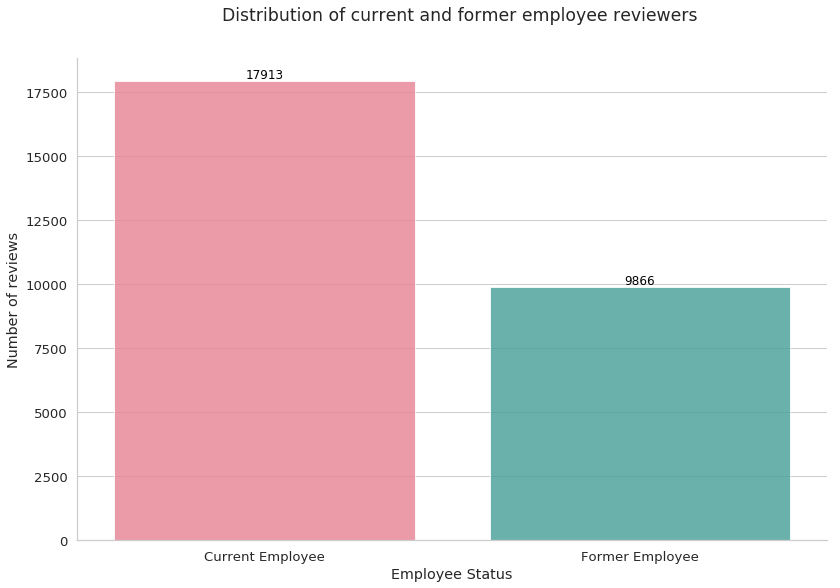

In [57]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

g = sns.factorplot(data=plot_df, x="current_employee",orient="h",kind = "count", legend_out = True,\
                   palette = "husl",alpha=0.8)
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.gcf().set_size_inches(17, 9)

g.set_xlabels('Employee Status')
g.set_ylabels('Number of reviews')
#g.set_title('Distribution of current and former employee reviewers')
g.fig.suptitle('Distribution of current and former employee reviewers')

# exact count on bars
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')



- Former Employee reviews are 35.55% of the total reviews.
- Current Employee reviews are 64.48% of the total reviews.

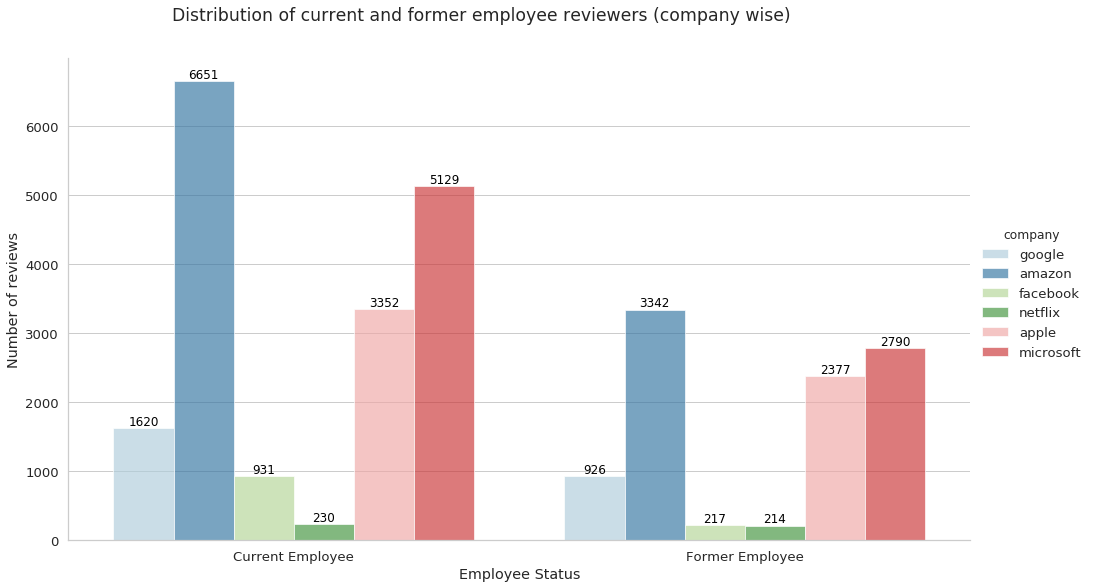

In [58]:

g = sns.factorplot(data=plot_df, x="current_employee",orient="h",\
                   kind = "count",hue='company', legend_out = True,palette = "Paired",alpha=0.65)
g.fig.subplots_adjust(top=0.9,right=0.9)
plt.gcf().set_size_inches(17, 9)
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")


g.set_xlabels('Employee Status')
g.set_ylabels('Number of reviews')
#g.set_title('Distribution of current and former employee reviewers')
g.fig.suptitle('Distribution of current and former employee reviewers (company wise)')

# exact count on bars
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')



- Amazon has the highest number of current and former employee reviews

### Plot the distributions of reviews for each company (current and former employees) and their overall ratings
- Hint: A Seaborn factorplot will work nicely here
    - https://kite.com/python/docs/seaborn.factorplot

In [59]:
#934 rows with all none
#28306

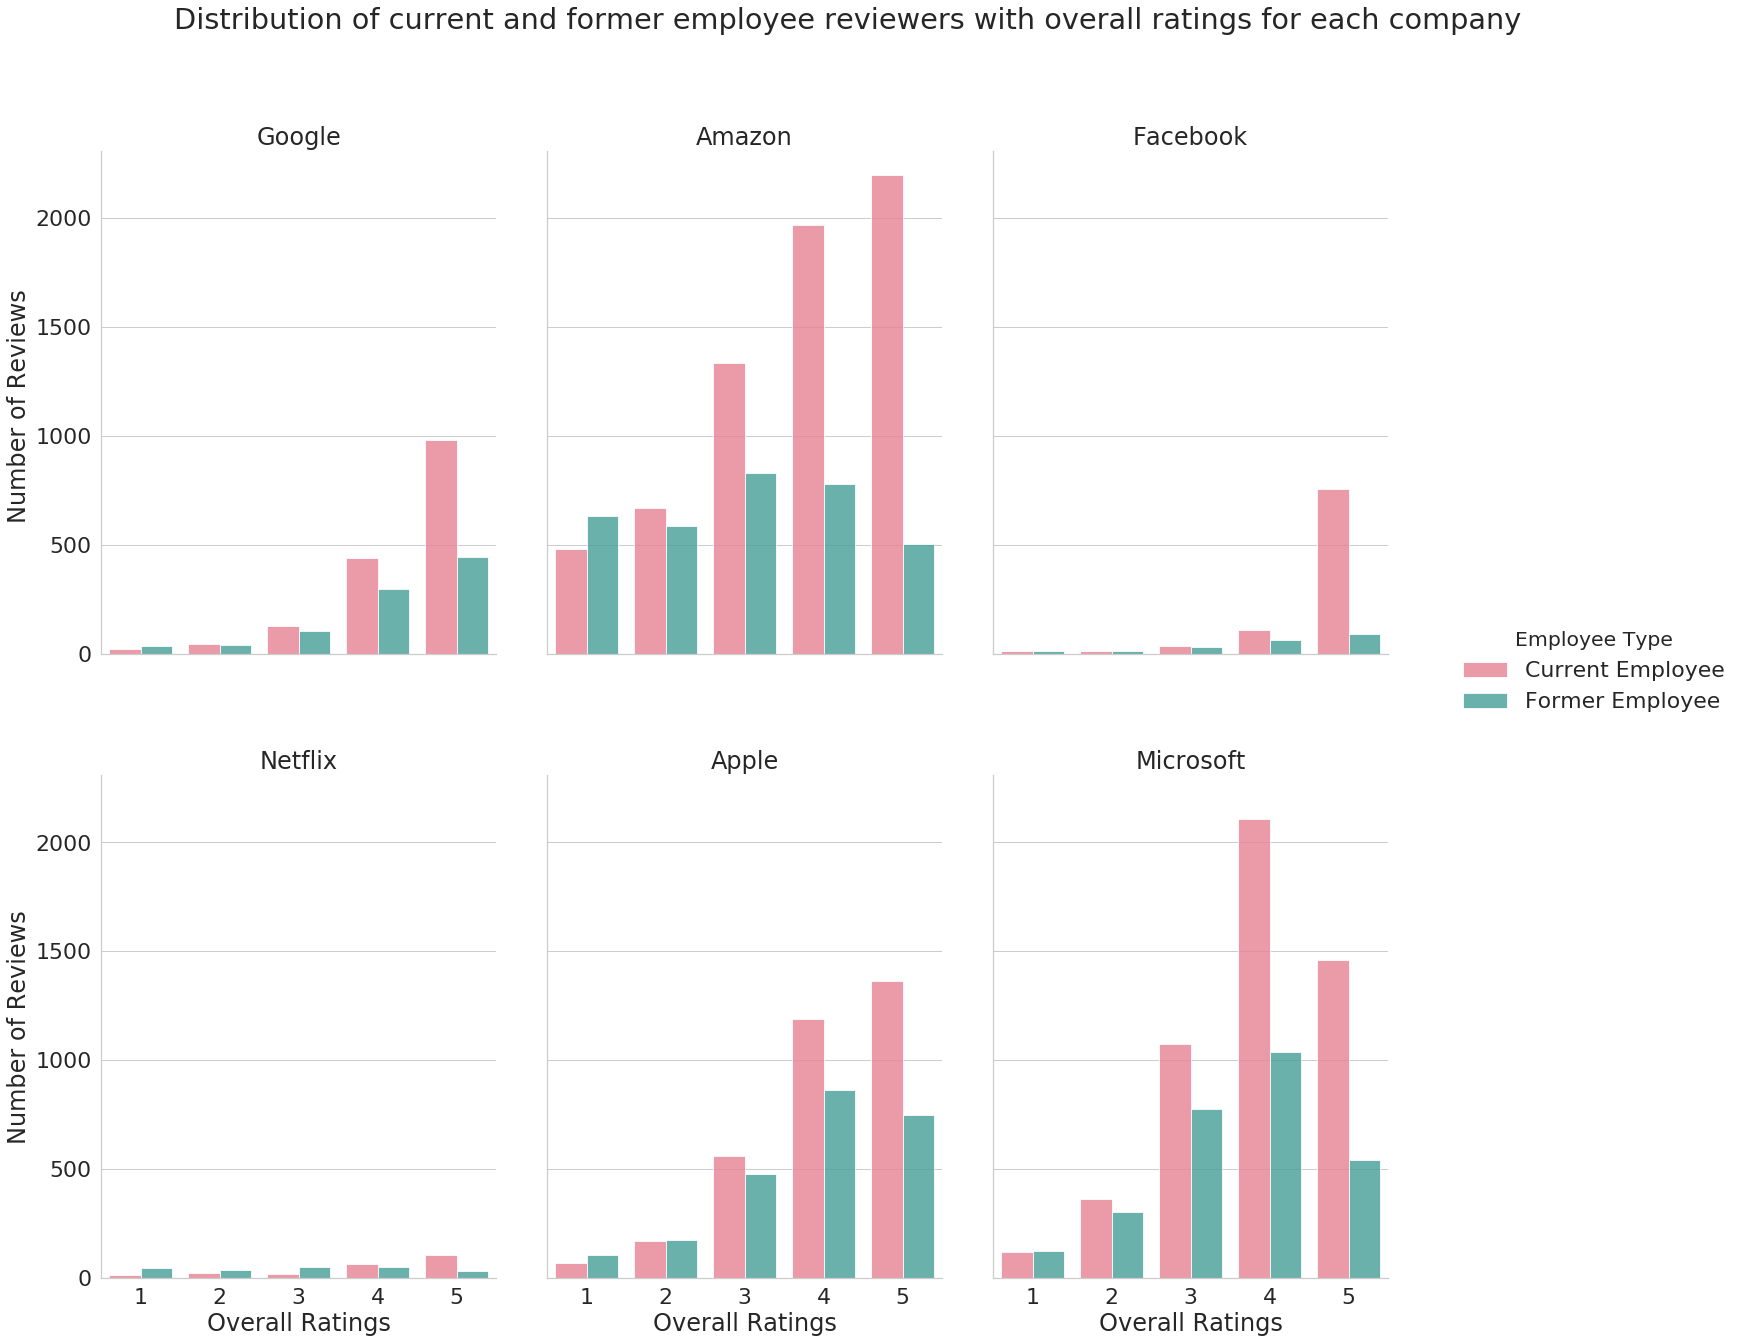

In [60]:
sns.set(font_scale = 2)
sns.set_style("whitegrid")

g=sns.factorplot(data=plot_df, x="overall_ratings", hue="current_employee",\
                 kind = "count", legend_out = True, col ="company", col_wrap = 3,palette = "husl",alpha=0.8)
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.gcf().set_size_inches(25,20)
g.fig.suptitle('Distribution of current and former employee reviewers with overall ratings for each company',\
               x= 0.5, y=1)
#plt.suptitle(country, x=0.1, y=.95, horizontalalignment='left', verticalalignment='top', fontsize = 15)


#each label

titles = ["Google", "Amazon", "Facebook", "Netflix", "Apple", "Microsoft"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    
    

titles = [" ", " ", " ", "Overall Ratings", "Overall Ratings", "Overall Ratings"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_xlabel(title)

titles = ["Number of Reviews ", " ", " ", "Number of Reviews", "   ", "   "]
for ax, title in zip(g.axes.flat, titles):
    ax.set_ylabel(title)    
    
#Legend
legend = g._legend
legend.set_title("Employee Type")
for t, l in zip(legend.texts,("Current Employee", "Former Employee")):
    t.set_text(l)





- Google has a similar trend in the former and current employee category but the number of reviews are lesser when compared to Amazon or Apple.
- Amazon`s most current employees have rated an overall 5 but former employees do not have the same opinion and they have rated a 3 most of the times.
- Facebook`s current employees have given an overall rating of 5 most of the times but the number of reviews are very less for Facebook
- Netflix has negligible reviews data
- Apple`s current employees have rated 5 most of the times and former employees have rated an overall 4 most of the times.
- Microsoft`s current and former employees both have rated 4 most of the times

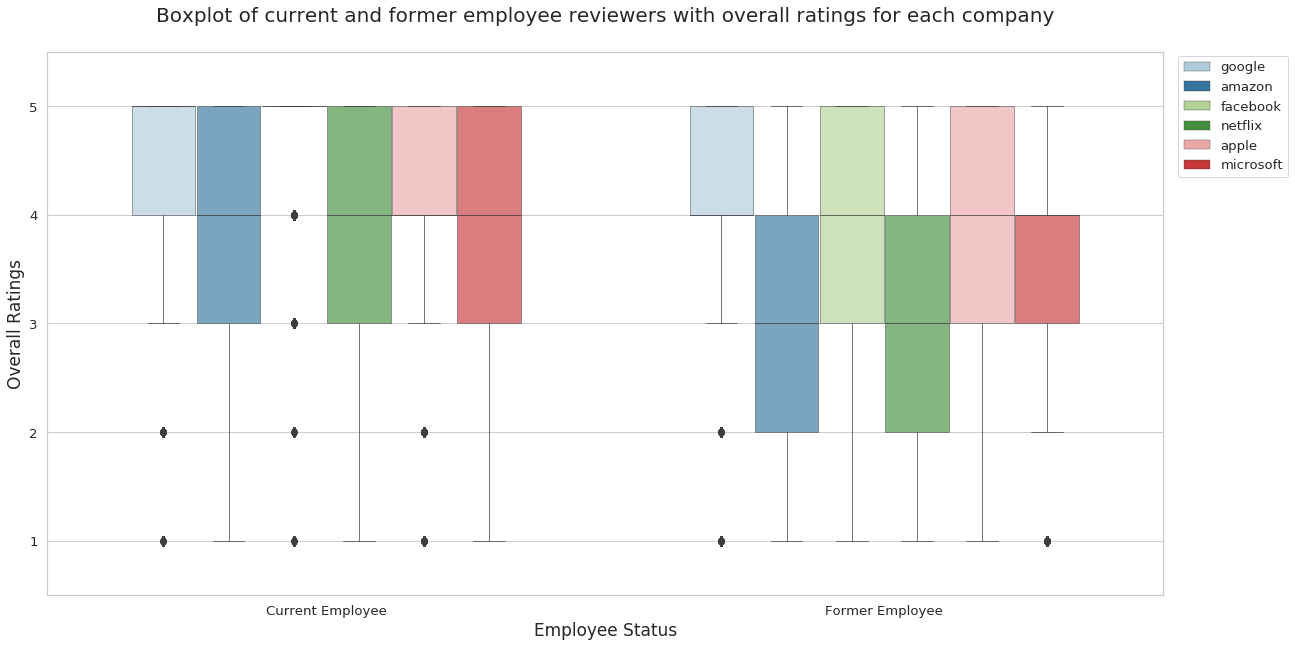

In [61]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
boxplot = sns.boxplot(data=plot_df,y="overall_ratings",x='current_employee',\
                      orient="v",hue="company",palette="Paired",\
                      saturation=0.7,width = 0.7,fliersize =7, linewidth = 0.7,notch = False,\
                      boxprops=dict(alpha=.65))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.gcf().set_size_inches(20, 10)
boxplot.set_ylim(0.5,5.5)




#labels
boxplot.set_xlabel('Employee Status',size=17)
boxplot.set_ylabel('Overall Ratings',size=17)
boxplot.set_title('Boxplot of current and former employee reviewers with overall ratings for each company',\
                  pad=30,size=20)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.3)
plt.show()

- Facebook has no boxplot visible for the current employees because its current employees have mostly rated an overall 5 and there are very few points for the other ratings
- Current employees tend to give higher ratings than the former employees

## Extra Plots

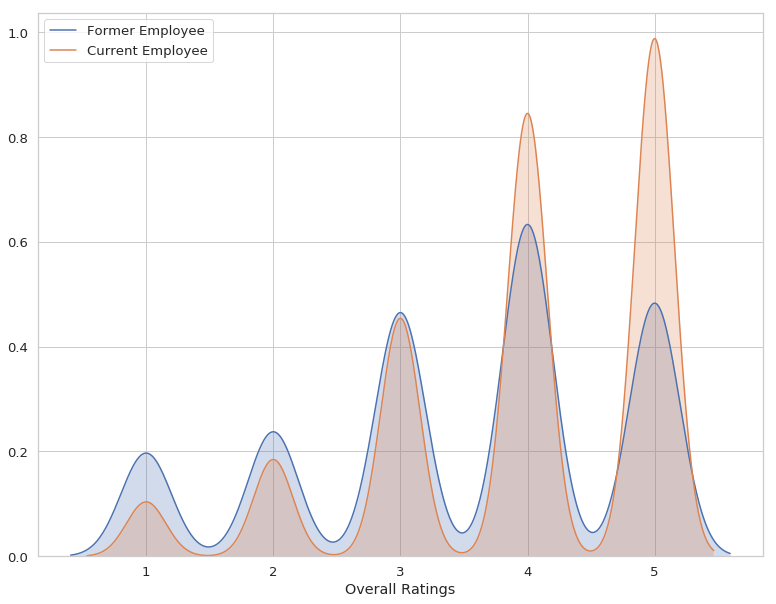

In [62]:
sns.kdeplot(plot_df.overall_ratings[plot_df.current_employee== "Former Employee"], label='Former Employee',\
            shade=True, gridsize=1000)
sns.kdeplot(plot_df.overall_ratings[plot_df.current_employee == "Current Employee"], label='Current Employee',\
            shade=True,gridsize= 1000)

plt.xlabel('Overall Ratings')
plt.gcf().set_size_inches(13, 10)

- Current employees have rated 5 more often than former employees

### --------------------------------------------------------------------------------------------------------------------------------

## Hints

In [63]:
#Cleaned Dataset


cleaned_df = df.where ((col("work_balance_stars") != "none") & (col("culture_values_stars") != "none")&
(col("carrer_opportunities_stars") != "none") & (col("comp_benefit_stars") != "none")& (col("senior_mangemnet_stars") != "none"))\
                         .select(
                             col("company"),
                             col("city"), col("state"), col("country"), col("review_date"), col("job_title"), col("current_employee"),
                            col("overall_ratings"), col("work_balance_stars"), col("culture_values_stars"), col("carrer_opportunities_stars"),
                            col("comp_benefit_stars"), col("senior_mangemnet_stars")
                         )



# Data Cleaning & Removing Un-Needed Columns

No one likes dirty data.  Let's clean up this dataset to make it more usable for our use case.

 
1. Make the date field more data friendly
    - Hint #1: Use the provided `review_date_udf` udf provided (it will make your life more simple) 
2. Using the "location" column 
    - Add new columns for city, state, country columns
        - Hint #1: Concider using `fn.split()` to split `location` for columns `city` `state` 
        - Hint #2: I've narrowed down the country to just US, so please use something like below to create the `country` column
            - ```lit("US").alias("country")```
3. Using the "job-title" column  
    - Add a new boolean column titled "current_employee" that will show:
        - 1,  if reviewer is a current employee
        - 0,  if reviewer is not a current employee
        - Hint:  Use spark function `fn.when()` and `col("job-title").contains("")`
    - Remove "Former Employee - " and "" from the "job-title" column
        - Hint: Use the udf function `reg_job_title_udf`
4. Drop un-needed columns 
    - "_c0", "link", "pros", "cons", "advice-to-mgmt", "summary", "location"

In [64]:
review_date_udf = fn.udf(
    lambda x: datetime.strptime(x, ' %b %d, %Y'), DateType()
)

In [65]:
def reg_job_title(column):
    res_split=[]
    reg_patterns=["Former Employee - / ", "Current Employee - / "]
    for i in range(len(reg_patterns)):
        res_split=re.findall(r"[^/]+",reg_patterns[i])
        for x in res_split[0].split("|"):
            column = column.replace(x,res_split[1])
    return column[1:]

#reg_job_title_udf = fn.udf(reg_job_title, t.StringType())



# Cleaned Spark Dataframe

- I've included the starting of dataframe, but in the `select` you will want to add the fixes and columns needed to answer the questions below


In [66]:
#cleaned_reviews_df = reviews_df.where((col("dates") != 'None') & (col("dates") != ' Jan 0, 0000') & (col("dates") != ' Nov 0, 0000') & (~col("location").contains("(")) & (col("location") != "none")) .select(col("company"),
                             
                        
#cleaned_reviews_df.show()


|company|         city|state|country|review_date|           job_title|current_employee|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|
+-------+-------------+-----+-------+-----------+--------------------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+
| google|Mountain View|   CA|     US| 2015-02-08|  Anonymous Employee|               1|            5.0|               2.0|                 5.0|                       5.0|               4.0|                   5.0|          498|
| google|Mountain View|   CA|     US| 2018-12-09|                SDE2|               0|            5.0|               4.0|                 4.0|                       4.0|               5.0|                   4.0|            1|
| google|     New York|   NY|     US| 2018-12-11|   Software Engineer|               1|            5.0|               5.0|                 4.0|                       4.0|               5.0|                   4.0|            0|
| google|     New York|   NY|     US| 2018-12-10|  Anonymous Employee|               1|            5.0|               5.0|                 5.0|                       5.0|               5.0|                   5.0|            0|
| google|Mountain View|   CA|     US| 2018-12-08|  Anonymous Employee|               1|            5.0|               4.0|                 5.0|                       4.0|               4.0|                   3.0|            0|
| google|San Francisco|   CA|     US| 2018-12-03|Sales Operations ...|               1|            5.0|               5.0|                 5.0|                       5.0|               4.0|                   4.0|            1|
| google|     New York|   NY|     US| 2018-11-26|            Designer|               1|            5.0|               3.0|                 4.0|                       3.0|               4.0|                   5.0|            2|
| google|  Los Angeles|   CA|     US| 2018-11-29|    Staff Accountant|               1|            5.0|               5.0|                 5.0|                       5.0|               5.0|                   5.0|            0|
| google|San Francisco|   CA|     US| 2018-11-17|   Program Manager I|               1|            5.0|               5.0|                 5.0|                       5.0|               5.0|                   5.0|            3|
| google|Mountain View|   CA|     US| 2018-12-09|     Senior Director|               0|            3.0|               4.0|                 5.0|                       5.0|               5.0|                   5.0|            0|
| google|Mountain View|   CA|     US| 2018-12-08|Software Engineer...|               1|            4.0|               5.0|                 5.0|                       4.0|               4.0|                   4.0|            0|
| google|     Dearborn|   MI|     US| 2018-11-20|   Google Specialist|               1|            5.0|               3.0|                 4.0|                       4.0|               5.0|                   4.0|            1|
| google|     New York|   NY|     US| 2018-12-06|  Anonymous Employee|               1|            4.0|               4.0|                 3.0|                       3.0|               4.0|                   3.0|            0|
| google|    Sunnyvale|   CA|     US| 2018-11-21|  Anonymous Employee|               1|            5.0|               3.0|                 5.0|                       5.0|               5.0|                   4.0|            0|
| google|      Seattle|   WA|     US| 2018-11-13|Staff Software En...|               1|            5.0|               4.0|                 4.0|                       5.0|               5.0|                   3.0|            2|
| google|     New York|   NY|     US| 2018-11-19|     Program Manager|               1|            5.0|               5.0|                 3.0|                       5.0|               4.0|                   5.0|            0|
| google|    Sunnyvale|   CA|     US| 2018-11-19|   Software Engineer|               1|            5.0|               5.0|                 5.0|                       4.0|               4.0|                   4.0|            0|
| google|    Ann Arbor|   MI|     US| 2018-11-19|Associate Account...|               0|            5.0|               4.0|                 4.0|                       5.0|               5.0|                   2.0|            0|
| google|Mountain View|   CA|     US| 2018-11-16|  Anonymous Employee|               1|            3.0|               2.0|                 1.0|                       2.0|               5.0|                   2.0|            8|
| google|Mountain View|   CA|     US| 2018-11-09|   Software Engineer|               1|            5.0|               5.0|                 5.0|                       5.0|               5.0|                   5.0|            1|
+-------+-------------+-----+-------+-----------+--------------------+----------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+
only showing top 20 rows